In [ ]:
#default_exp core

# Core XLA extensions

In [ ]:
#hide
#colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#hide
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#hide
#colab
!curl -s https://course.fast.ai/setup/colab | bash 

## Install fastai2

In [ ]:
#hide_output
#colab
!pip install fastai2 > /dev/null

## Setup torch XLA


In [ ]:
#hide_output
#colab
VERSION = "20200707"  #@param ["1.5" , "20200325","20200707", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  16446      0 --:--:-- --:--:-- --:--:-- 16446
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200707 ...
     |████████████████████████████████| 61kB 2.7MB/s 
Uninstalling torch-1.6.0+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.6.0+cu101
Uninstalling torchvision-0.7.0+cu101:
  Successfully uninstalled torchvision-0.7.0+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
- [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    


In [ ]:
#hide
!pip freeze | grep torch
!pip freeze | grep fastai2

torch==1.7.0a0+12b5bdc
torch-xla==1.6+5430aca
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.0a0+86b6c3e
fastai2==0.0.23


In [ ]:
#hide
#colab
%cd /content/drive/My\ Drive/fastai_xla_extensions

/content/drive/My Drive/fastai_xla_extensions


## Check if XLA is available

In [ ]:
#hide
XLA_AVAILABLE = False

In [ ]:
#export
#colab
XLA_AVAILABLE = True
try:
    import torch_xla.core.xla_model as xm
except ImportError as e:
    XLA_AVAILABLE = False
    import warnings
    # warnings.warn('fastai_xla_extensions requires Pytorch-XLA, will revert to default',
    #              RuntimeWarning)

## Fake XLA functionality if XLA not available
if TPU not available, fake xm to call opt.step anyway, 
and fake xla_device to return gpu if available, else return cpu
to ensure compatible behavior in using fastai_xla_extensions as 
normal fastai behavior if TPU not available

In [ ]:
#export
if not XLA_AVAILABLE:
    from types import SimpleNamespace
    import torch.cuda
    def fake_opt_step(opt,barrier=False): 
        opt.step()
    def fake_device(n=None, devkind=None):
        gpu_available = torch.cuda.is_available() 
        return torch.device(torch.cuda.current_device()) if gpu_available else torch.device('cpu')
    xm = SimpleNamespace(
        optimizer_step = fake_opt_step,
        xla_device = fake_device
    )
    

## Add TPU info to defaults if XLA available

In [ ]:
#export
if XLA_AVAILABLE:
    from fastcore.foundation import defaults
    defaults.tpu_device = xm.xla_device(devkind='TPU')
    defaults.tpu_available = defaults.tpu_device != None 

## Monkey patch `default_device` and `to_device` to use TPU if tpu is available
Replace `fastai2.torch_core.default_device` and `fastai2.torch_core.to_device`
with ones that will return the TPU device assuming a TPU is available 
(and CPU is not explicitly requested)

In [ ]:
#export
if XLA_AVAILABLE and defaults.tpu_available:
    import fastai2.torch_core
    from fastai2.torch_core import apply
    from torch import Tensor
    def default_device(use_cuda=-1):
        "Return `TPU` as default device"
        return defaults.tpu_device
    def to_device(b, device=None):
        "Recursively put `b` on `device`."
        if device is None: device=default_device()
        # print(f'setting device to {device}')
        def _inner(o): return o.to(device, non_blocking=True) if isinstance(o,Tensor) else o.to_device(device) if hasattr(o, "to_device") else o
        return apply(_inner, b)

    fastai2.torch_core.default_device = default_device
    fastai2.torch_core.to_device = to_device
    

## XLA Optim Proxy
`XLAOptimProxy` is a class which has overridden the `step` method to call the Pytorch-XLA function `xm.optimizer_step` which synchronizes the XLA graph. All other calls to `XLAOptimProxy` just forward it to the internal `self.opt` instance.

In [ ]:
#export
class XLAOptimProxy:
    "Proxy optimizer to override `opt.step` with Pytorch XLA sync method `xm.optimizer_step` "  
    def __init__(self,opt, barrier=True):
        self.opt = opt
        self._barrier = barrier
        
    def xla_step(self):
        xm.optimizer_step(self.opt,barrier=self._barrier) # sync on gradient update
        
    def __getattr__(self,name):
        if name == 'step': # override proxying for step
            return getattr(self,'xla_step')
        if name in ('barrier','_barrier'):
            return getattr(self,name)
      
        # proxy everything else
        return getattr(self.opt,name)
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v 

## XLA Opt Callback
This callback replaces the learner's `opt` with an instance of `XLAOptimProxy` that proxies the original `opt` during the beginning of the `fit` method and restores the original `opt` after the `fit`.

In [ ]:
#export
from fastai2.callback.core import Callback

class XLAOptCallback(Callback):
    'Callback to replace `opt.step` with `xm.optimizer_step(opt)` as required to run on TPU'
    def __init__(self, barrier=True):
        self._barrier = barrier
  
    def begin_fit(self):
        'replace opt with proxy which calls `xm.optimizer_step` instead of `opt.step`'        
        if self.learn.opt is not None:
            if not isinstance(self.learn.opt,XLAOptimProxy):
                opt = self.learn.opt
                self.learn.opt = XLAOptimProxy(opt, barrier=self._barrier)
                
    def after_fit(self):
        'restore original opt '
        if isinstance(self.learn.opt, XLAOptimProxy):
            opt = self.learn.opt.opt
            self.learn.opt = opt
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v

## Add XLOptCallback to list of default callbacks if tpu is available

In [ ]:
#export
if XLA_AVAILABLE and defaults.tpu_available:
    if hasattr(defaults,'callbacks'):
        if XLAOptCallback not in defaults.callbacks: 
            defaults.callbacks.append(XLAOptCallback)
    else:
        defaults.callbacks = [XLAOptCallback]

## Example: Create an MNIST classifier
This is an example of the fastai_xla_extensions library
in action.

First, we import fastai libraries. 

In [ ]:
#hide
#colab
%cd /content

/content


In [ ]:
from fastai2.vision.all import *

Load data

In [ ]:
path = untar_data(URLs.MNIST_TINY)
Path.BASE_PATH = path

Create datablock

_(note: `batch_tfms` is empty -- this is still being debugged for slow performance)_

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)

Set dataloader to load the batches to the tpu

In [ ]:
dls = datablock.dataloaders(path)

In [ ]:
#colab
dls.device

device(type='xla', index=1)

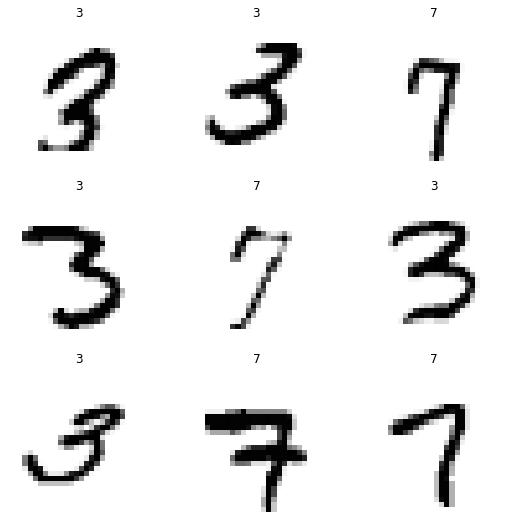

In [ ]:
dls.show_batch()

In [ ]:
#colab
xb,yb = dls.one_batch()
(xb.device, xb.shape)

(device(type='xla', index=1), torch.Size([64, 1, 28, 28]))

Create the Learner

In [ ]:
learner = cnn_learner(dls, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


The learner.opt should be an instance of  fastai `Optimizer`

In [ ]:
learner.opt

The `learner` object should have an `xla_opt` attribute which confirms that `XLAOptCallback` has been added to the list of callbacks for this learner.

In [ ]:
#colab
learner.xla_opt

XLAOptCallback

In [ ]:
#colab
learner.xla_opt.barrier

True

In [ ]:
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

Run fine_tune to train the model

In [ ]:
#colab
learner.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.877254,0.272907,0.889843,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.357303,0.169594,0.937053,00:09


Run LR Finder to find best values for discriminative learning

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=6.918309736647643e-06)

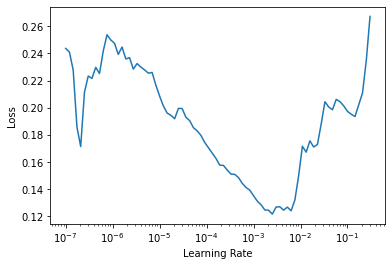

In [ ]:
#colab
learner.unfreeze()
learner.lr_find()

In [ ]:
#colab
learner.fit_one_cycle(4, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.212356,0.213779,0.905579,00:07
1,0.183420,0.214454,0.915594,00:02
2,0.172335,0.168369,0.932761,00:02
3,0.162608,0.155168,0.939914,00:02


Valid loss still trending down -- looks like more epochs needed to improve model.

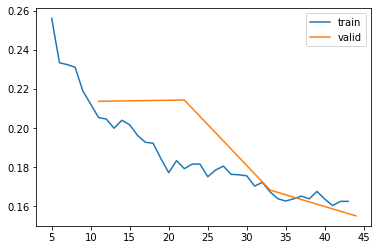

In [ ]:
#colab
learner.recorder.plot_loss()

Plot moms and lr across batches/epochs

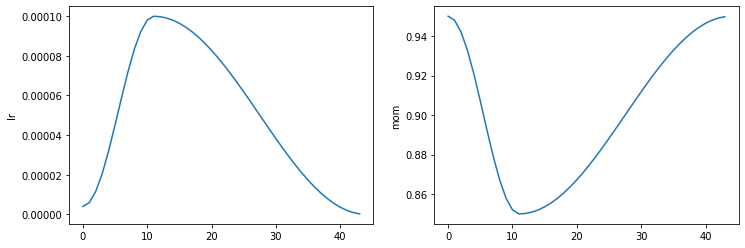

In [ ]:
#colab
learner.recorder.plot_sched()

Get Classification Interpretation for more details on model performance

In [ ]:
#colab
interp = ClassificationInterpretation.from_learner(learner)

Plot confusion matrix

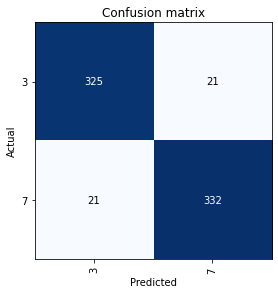

In [ ]:
#colab
interp.plot_confusion_matrix()

Samples where model was most confused

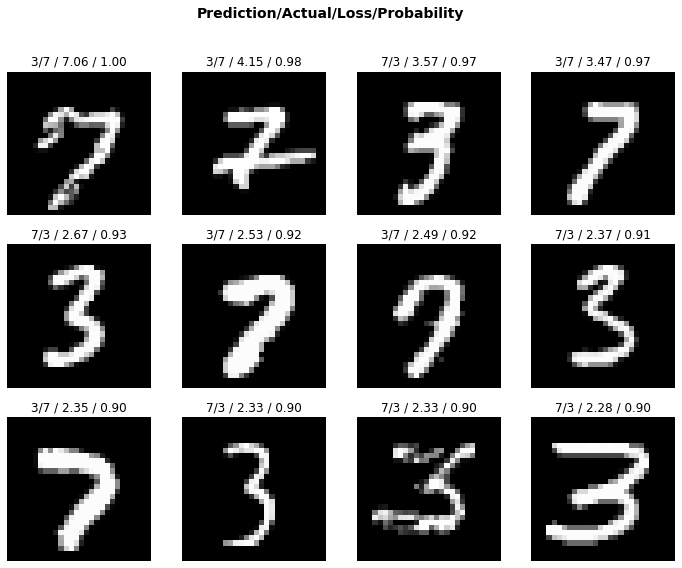

In [ ]:
#colab
interp.plot_top_losses(12)

Gradient Accum callback (which calls CancelBatchException) should still work.

An alternative design for the XLA Opt Callback which raises the CancelBatchException in the `after_backward` method (after executing `xm.optimizer_step` and `opt.zero_grad`) would interfere with the Gradient Accum callback (which raises `CancelBatchException` in the `after_backward` method to [skip the gradient updates](https://github.com/fastai/fastai2/blob/master/fastai2/callback/training.py#L22) in order to accumulate the gradients).

The current design (add/remove `XLAOptimProxy` during `begin_fit` and `after_fit` callback lifecycle methods) is less disruptive and more compatible with other callbacks.

In [ ]:
#colab
from fastai2.callback.training import *
learner.fit_one_cycle(4,cbs=[GradientAccumulation(n_acc=2),])

epoch,train_loss,valid_loss,accuracy,time
0,0.092523,0.035261,0.984263,00:02
1,0.134345,0.342893,0.954220,00:02
2,0.110381,0.127353,0.979971,00:02
3,0.079561,0.002343,1.000000,00:02
